(adaptive-step-size-control-section)=

# Adaptive step size control

The implementations of the Runge-Kutta methods that we have used previously in this chapter have used a constant value of the step length $h$. Using a fixed step length does not allow the method to take advantage of increasing the step length where the behaviour of the solution allows. Adaptive step size control is a method that attempts to control the value of the step length based on accuracy requirements. The accuracy of the approximation to the solution to the ODE is dependent upon three factors

- the order of accuracy of the computational method;
- the size of the step length used to advance the solution;
- the behaviour of the solution.
  
Improving the order of accuracy of the method is often not straightforward and can place restrictions on the applicability of the method. Reducing the step length used will improve the accuracy of the approximation but since more steps are required to advance through the domain, this will increase the computational cost. The behaviour of the solution will have an effect on the accuracy of the approximation because computational methods are more accurate where the solution is slowly varying and less accurate where there are rapid variations in the solution.

For each step of the algorithm we compute two solutions of order $p$ and $p+1$ and calculate the difference between the two solutions. If this difference is within a desired accuracy tolerance, then the step is considered to be **successful** and the algorithm proceeds onto the next step and the step length is increased. If this is not the case then the step is considered to have **failed** and is repeated using a smaller step length.

---

## Absolute and relative tolerances

When determining whether a solution step is accurate enough we need to consider the size of the values involved. Consider the case where we are applying a population model where the solution values are expected to be large. Let's say that the solutions for a step are $y^{(p)} = 1000000$ for the order $p$ method and $y^{(p+1)} = 1000100$ for the order $p + 1$ method. If we were to use the **absolute difference** the two solutions then we have

$$ \textsf{absolute difference} = | y^{(p+1)} - y^{(p)} | = | 1000100 - 1000000 | = 100. $$

So if we set our accuracy tolerance to $10^{-3}$ the step would consider to have failed and we would repeat the step. However, if we calculate the difference between $y^{(p+1)}$ relative to $y^{(p)}$, known as the **relative difference**, we have

$$ \textsf{relative difference} = \frac{|y^{(p+1)} - y^{(p)}|}{|y^{(p)}|} = \frac{|1000100 - 1000000|}{|1000000|} = 10^{-4}, $$

which is less than $10^{-3}$ and the step would consider to be successful.

Now consider a case where we are applying a chemical kinetics model where the solution values are expected to be very small. If the solutions for a step are $y^{(p)} = 1 \times 10^{-6}$ and $y^{(p+1)} = 2\times 10^{-6}$ then relative difference is

$$ \textsf{relative difference} = | y^{(p+1)} - y^{(p)} | = \frac{| 2\times 10^{-6} - 1 \times 10^{-6} |}{|1 \times 10^{-6}|} = 1, $$

which is a lot greater than the accuracy tolerance of $10^{-3}$ and the step would consider to have failed. But the absolute difference is

$$ \textsf{absolute difference} = | y^{(p+1)} - y^{(p)} | = | 2\times 10^{-6} - 1 \times 10^{-6} | = 10^{-6}, $$

which is a lot less than the accuracy tolerance and the step would consider to be successful. 

So when the values of the solution are large we use the relative difference between the two solutions, and when the values of the solution are small we use the absolute difference. But we want an algorithm that can deal with both cases. To do this we use two accuracy tolerances, $atol$ and $rtol$ for the absolute and relative differences respectively such that $atol < rtol$, and compare the absolute difference between the two solutions so that a step is considered to have been successful if

$$ |y^{(p+1)} - y^{(p)}| < atol + rtol \cdot |y^{(p+1)}|. $$

Using $atol = 10^{-6}$ and $rtol = 10^{-3}$ for the population model example we have

$$ atol + rtol \cdot |y^{(p+1)}| = 10^{-6} + 10^{-3} \cdot |1000100| = 1000.100001. $$

Since $100 < 1000.100001$ the step is considered to be successful. Alternatively, for the chemical kinetics example we have

$$ atol + rtol \cdot |y^{(p+1)}| = 10^{-6} + 10^{-3} \cdot |2\times 10^{-6}| = 1.002\times 10^{-6}, $$

and since $10^{-6} < 1.002\times 10^{-6}$ the step is considered to be successful.

---

## Calculating the new step length

At each step in the method we will be adjusting the value of the step length. If a step has failed we want to reduce the value of the step length so that the solution is more accurate. If a step is successful this indicates the step length used could have been larger, so we want to increase it but not too much as to result in a failed step in the next step.

Let $y^{(p)}$ and $y^{(p+1)}$ denote the numerical solutions calculated using the order $p$ and $p+1$ method respectively and $y$ denote the exact solution then 

$$ \begin{align*}
    y &= y^{(p)} + O(h^{p+1}), \\
    y &= y^{(p+1)} + O(h^{p+2}).
\end{align*} $$

Subtracting the second equation from the first gives

$$ \begin{align*}
    0 &= y^{(p)} - y^{(p+1)} + O(h^{p+1}) + O(h^{p+2}) \\
    |y^{(p+1)} - y^{(p)}| &= O(h^{p+1}) + O(h^{p+2}).
\end{align*} $$

If we let $\Delta = |y^{(p)} - y^{(p+1)}|$ and since $O(h^{p+1}) + O(h^{p+2}) = O(h^{p+1})$ (the larger error dominates the smaller one) then by the definition of $O(h^n)$

$$ \Delta = Ch^{p+1}. $$

We want to calculate a new step length $h_{new}$ which results in a desired accuracy tolerance $tol$, i.e.,

$$ tol = Ch_{new}^{p+1},$$

and defining a ratio $r$ between the new step length and current step length, $r = h_{new} / h$, then

$$ \begin{align*}
    \frac{Ch_{new}^{p+1}}{Ch^{p+1}} &= \frac{tol}{\Delta} \\
    r^{p+1} &= \frac{tol}{\Delta} \\
    r &= \left( \frac{tol}{\Delta} \right)^{\frac{1}{p+1}}.
\end{align*} $$

So when $\Delta < tol$, $r < 1$ and the step length is decreased, and when $\Delta > tol$, $r > 1$ and the step length is increased. To prevent the step length being decreased too much we limit the value of $r$ to 0.1 so that the step length is decreased by a maximum of one tenth each step (the value of 0.1 is arbitrary). Also, we limit the amount by which the step length is increased by a *safety factor* of 0.8 to prevent the future step failing. 

$$ r = \max\left(0.1, 0.8 \left( \dfrac{tol}{\Delta} \right)^{\frac{1}{p+1}} \right). $$

We can use the value of $rtol$ to give us an approximation for the initial value of $h$

$$ h = 0.8 \cdot rtol ^ {^\frac{1}{p+1}}. $$

---

## Embedded Runge-Kutta methods

German mathematician Erwin Fehlberg (1911 - 1990) derived a Runge-Kutta method where different weightings applied to the stage values can result in a method of fourth or fifth-order without having to repeat the calculations of the ODE function. Since Fehlberg's original method, several other Runge-Kutta methods that use the same stage values for producing solutions of different orders have been suggested and these methods are known as <a href="https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Embedded_methods" target="_blank">**embedded Runge-Kutta methods**</a>.

The Butcher tableau for an embedded Runge-Kutta method takes the form 

$$ \begin{align*}
    \begin{array}{c|ccccc}
        0 & 0 \\
        c_2 & a_{21} \\
        c_3 & a_{31} & a_{32} \\
        \vdots & \vdots & \vdots & \ddots \\
        c_s & a_{s1} & a_{s2} & \cdots & a_{s,s-1} \\ \hline
        & b_1 & b_2 & \cdots & b_{s-1} & b_s \\
        & b_1^* & b_2^* & \cdots & b_{s-1}^* & b_s^*
    \end{array}
\end{align*} $$

Where the weights $b_i$ and $b_i^*$ that give an order $p+1$ and $p$ method respectively, i.e.,

$$ \begin{align*}
    y_{n+1}^{(p+1)} &= y_n + h (b_1 k_1 + b_2 k_2 + \cdots + b_s k_s), \\
    y_{n+1}^{(p)} &= y_n + h (b_1^* k_1 + b_2^* k_2 + \cdots + b_s^* k_s),
\end{align*} $$

where $k_i$ are the same for both equations. Examples of embedded Runge-Kutta methods are the Bogacki-Shampine 3(2) method and Fehlberg's 5(4) method.


```{prf:definition} Bogacki-Shampine 3(2) Runge-Kutta method (RK23)
:label: bogacki-shampine-equation

$$ \begin{align*}
    \begin{array}{c|cccc}
        0 & \\
        1/2 & 1/2 \\
        3/4 & 0 & 3/4 \\
        1 & 2/9 & 1/3 & 4/9 \\ \hline
        & 2/9 & 1/3 & 4/9 & 0 \\
        & 7/24 & 1/4 & 1/3 & 1/8
    \end{array}
\end{align*} $$

{cite:t}`bogacki:1989`
```

```{prf:definition} Fehlberg's order 5(4) Runge-Kutta method (RKF45)
:label: fehlbergs-method-equation

$$ \begin{array}{c|cccccc}
    0 & 0 \\
    1/4 & 1/4 \\
    3/8 & 3/32 & 9/32 \\
    12/13 & 1932/2197 & -7200/2197 & 7296/2197 \\
    1 & 439/216 & -8 & 3680/513 & -845/4104 \\
    1/2 & -8/27 & 2 & -3544/2565 & 1859/4104 & -11/40 \\ \hline
    & 16/135 & 0 & 6656/12825 & 28561/56430 & -9/50 & 2/55 \\
    & 25/216 & 0 & 1408/2565 & 2197/4104 & -1/5 & 0 
\end{array} $$

{cite:t}`fehlberg:1969`
```

```{prf:algorithm} Solving an IVP using a single step method with adaptive step size control
:label: step-size-control-algorithm

**Inputs** A system of first-order ODEs of the form $\mathbf{y}' = f(t,\mathbf{y})$, the domain $t \in [t_0, t_{\max}]$, the initial values $\mathbf{y}(t_0) = \mathbf{y}_0$, and desired accuracy tolerances $atol$ and $rtol$.

**Outputs** $(t_0, t_1, \ldots)$ and $(\mathbf{y}_0, \mathbf{y}_1, \ldots)$.

- $h \gets 0.8 \cdot rtol^{^\frac{1}{p+1}}$
- $n \gets 0$
- While $t_n < b$
    - Calculate the $\mathbf{y}^{(p+1)}$ and $\mathbf{y}^{(p)}$ solutions
    - $\Delta \gets \| \mathbf{y}^{(p+1)} - \mathbf{y}^{(p)} \|$
    - $tol \gets atol + rtol \cdot \min (| \mathbf{y}^{(p+1)} |)$
    - If $\Delta < tol$
      - $\mathbf{y}_{n+1} \gets \mathbf{y}^{(p+1)}$
      - $t_{n+1} \gets t_n + h$
      - $n \gets n + 1$
    - $r \gets \max \left(0.1, 0.8 \left( \dfrac{tol}{\Delta} \right) ^{1/(p+1)} \right)$
    - $h \gets \min(h, t_{\max} - t_n)$
- Return $(t_0, t_1, \ldots)$ and $(\mathbf{y}_0, \mathbf{y}_1, \ldots)$
```

````{prf:example}
:label: embedded-rk-example

Use Bogacki-Shampine method to solve the following IVP using accuracy tolerances of $atol = 10^{-6}$ and $rtol = 10^{-3}$

$$ y' = e^{t - y \sin(y)}, \qquad t \in [0, 5], \qquad y(0) = 0.$$ 

---

**Solution**

Here $f(t, y) = e^{t - y\sin(y)}$, $t= 0$ and $y_0 = 0$. Calculating the initial step length gives

$$ h = 0.8 (rtol)^{^\frac{1}{3}} = 0.8(10^{-3})^{^\frac{1}{3}} = 0.8.$$


Calculating the first step of the Bogacki-Shampine 3(2) method gives

$$ \begin{align*}
    y^{(3)} &= 0.083096, \\
    y^{(2)} &= 0.083081.
\end{align*} $$ 

Calculate $\Delta$ and $tol$

$$ \begin{align*}
    \Delta &= \| y^{(3)} - y^{(2)} \| = 0.083096 - 0.083081 = 1.563 \times 10^{-5}, \\
    tol &= atol + rtol \cdot \|y^{(3)}\| = 10^{-6} + 10^{-3}(0.083096) = 8.410 \times 10^{-5},
\end{align*} $$

so $\Delta < tol$ and the step has been successful. Calculating the new value of $h$

$$ \begin{align*}
    h = h \left( 0.1, 0.8 \left( \frac{tol}{\Delta} \right)^{^\frac{1}{3}} \right) = 0.8 \left(0.1, 0.8 \left( \frac{8.410 \times 10^{-5}}{1.563 \times 10^{-5}} \right)^{^\frac{1}{3}} \right) = 0.112145.
\end{align*} $$

The solution over the full domain $t\in [0, 5]$ is shown in {numref}`rk23-example-figure`. 

```{glue:figure} rk23-example-plot
:name: rk23-example-figure

Bogacki-Shampine 3(2) method solution to the initial value problem $y' = -21y + e^{-t}$, $t\in [0,1]$, $y(0)=0$ with an initial step length $h=0.1$ and an accuracy tolerance $tol=10^{-4}$.
```

A plot of the step lengths used across the domain is shown in {numref}`rk23-example-step-size-plot-figure`. Note how the step lengths decrease where the solution is steeper and increase where it is more slowly varying. 

```{glue:figure} rk23-example-step-size-plot
:name: rk23-example-step-size-plot-figure

Bogacki-Shampine 3(2) method solution to the initial value problem $y' = -21y + e^{-t}$, $t\in [0,1]$, $y(0)=0$ with an initial step length $h=0.1$ and an accuracy tolerance $tol=10^{-4}$.
```

````


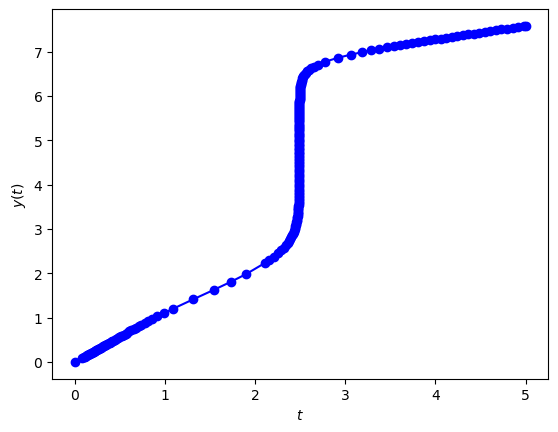

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def rk23(f, tspan, y0, atol=1e-6, rtol=1e-3):

    m = len(y0)
    t = np.zeros(100000)
    y = np.zeros((100000, m)) 
    t[0] = tspan[0]
    y[0,:] = y0
    
    h = 0.8 * rtol ** (1 / 3)
    n = 0
    while t[n] < tspan[-1]:

        k1 = f(t[0], y[0,:])
        k2 = f(t[n] + 1/2 * h, y[n,:] + 1/2 * h * k1)
        k3 = f(t[n] + 3/4 * h, y[n,:] + 3/4 * h * k2)
        k4 = f(t[n] + h, y[n,:] + h * (2/9 * k1 + 1/3 * k2 + 4/9 * k3))
        y3 = y[n,:] + h * (2/9 * k1 + 1/3 * k2 + 4/9 * k3)
        y2 = y[n,:] + h * (7/24 * k1 + 1/4 * k2 + 1/3 * k3 + 1/8 * k4)

        delta = np.linalg.norm(y3 - y2)
        tol = atol + rtol * np.min(np.abs(y3))
        if delta < tol:
            y[n+1,:] = y3
            t[n+1] = t[n] + h
            n += 1
        
        r = max(0.1, 0.8 * (tol / delta) ** (1/3))
        h = min(r * h, tspan[-1] - t[n])

    return t[:n+1], y[:n+1,:]

    
# Define the ODE function and exact solution
def f(t, y):
    return np.exp(t - y * np.sin(y))


# Define IVP
tspan = [0, 5]  # boundaries of the t domain
y0 = [0]        # initial values

# Calculate the solution to the IVP
t, y = rk23(f, tspan, y0)

# Plot solutions (rk23)
fig, ax = plt.subplots()
plt.plot(t, y, "b-o")
plt.xlabel("$t$")
plt.ylabel("$y(t)$")

from myst_nb import glue
glue('rk23-example-plot', fig, display=False)

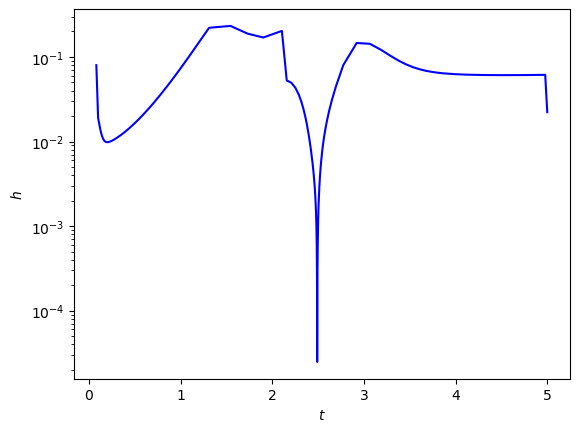

In [2]:
fig, ax = plt.subplots()
plt.semilogy(t[1:], t[1:] - t[:-1], 'b')
plt.xlabel('$t$')
plt.ylabel('$h$')
plt.show()

from myst_nb import glue
glue('rk23-example-step-size-plot', fig, display=False)


---

(ssc-code-section)=

##  Code

The code below defines the function `rkf23()` which computes the solution to an initial value problem using the Bogacki-Shampine 3(2) embedded Runge-Kutta method. Since we do not know beforehand how many steps will be required, we assume the number steps will be large and use a while loop instead of a for loop for stepping through the solution. 

`````{tab-set}
````{tab-item} Python
```python
def rk23(f, tspan, y0, atol=1e-6, rtol=1e-3):

    m = len(y0)
    t = np.zeros(100000)
    y = np.zeros((100000, m)) 
    t[0] = tspan[0]
    y[0,:] = y0
    
    h = 0.8 * rtol ** (1 / 3)
    n = 0
    while t[n] < tspan[-1]:

        k1 = f(t[0], y[0,:])
        k2 = f(t[n] + 1/2 * h, y[n,:] + 1/2 * h * k1)
        k3 = f(t[n] + 3/4 * h, y[n,:] + 3/4 * h * k2)
        k4 = f(t[n] + h, y[n,:] + h * (2/9 * k1 + 1/3 * k2 + 4/9 * k3))
        y3 = y[n,:] + h * (2/9 * k1 + 1/3 * k2 + 4/9 * k3)
        y2 = y[n,:] + h * (7/24 * k1 + 1/4 * k2 + 1/3 * k3 + 1/8 * k4)

        delta = np.linalg.norm(y3 - y2)
        tol = atol + rtol * np.min(np.abs(y3))
        if delta < tol:
            y[n+1,:] = y3
            t[n+1] = t[n] + h
            n += 1
        
        r = max(0.1, 0.8 * (tol / delta) ** (1/3))
        h = min(r * h, tspan[-1] - t[n])

    return t[:n+1], y[:n+1,:]
```
````

````{tab-item} MATLAB
```matlab
function [t, y] = rk23(f, tspan, y0, atol, rtol)

m = length(y0);
t = zeros(100000, 1);
y = zeros(100000, m);
t(1) = tspan(1);
y(1,:) = y0;

h = 0.8 * rtol ^ (1/3);
n = 1;
while t(n) < tspan(2)

    k1 = f(t(n), y(n,:));
    k2 = f(t(n) + 1/2 * h, y(n,:) + 1/2 * h * k1);
    k3 = f(t(n) + 3/4 * h, y(n,:) + 3/4 * h * k2); 
    k4 = f(t(n) + h, y(n,:) + h * (2/9 * k1 + 1/3 * k2 + 4/9 * k3));
    y3 = y(n,:) + h * (2/9 * k1 + 1/3 * k2 + 4/9 * k3); 
    y2 = y(n,:) + h * (7/24 * k1 + 1/4 * k2 + 1/3 * k3 + 1/8 * k4);

    delta = norm(y3 - y2);
    tol = atol + rtol * min(abs(y3));
    if delta < tol
        y(n+1,:) = y3;
        t(n+1) = t(n) + h;
        k1 = k4;
        n = n + 1;
    end

    r = max(0.1, 0.8 * (tol / delta) ^ (1/3));
    h = min(r * h, tspan(2) - t(n));
end

t(n+1:end) = [];
y(n+1:end,:) = [];

end
```
````

`````